# Optimal Brain Damage (OBD)

## Introduction

**Performance-complexity tradeoff** (aka bias-variance tradeoff): Too complex models do not generalize well enough and too simple models don't represent data well enough. 

One way to address tradeoff is by adding complexity penalty in objective function:

$$
\text{Objective}
= \underbrace{\text{Loss term}}_{\text{Data fit}}
+ \lambda\,\underbrace{\text{Complexity term}}_{\text{Regularization}}
$$

Assuming more parameters increases complexity and less parameters decreases complexity, i.e. **number of parameters $\propto$ complexity**, another way to address the performance-complexity tradeoff is by **pruning** unimportant parameters.

Once the parameters to prune are decided, pruning can be applied in different ways: 
* Can set the parameters to zero (**hard magnitude pruning**) OR drastically decrease the parameters, but keep non-zero (**soft magnitude pruning**)
* Can freeze the weights after applying the decrease (**hard-prune**) OR can allow them to adapt when re-training the model (**soft-prune**)

Benefits of  **pruning** include:
* Better generalization
* Sample efficiency
* Improved training and inference speed

Deciding which parameters to prune is not as straightforward in neural networks as it is in other models with priori structural information, e.g. when deciding which parameters to prune in polynomial regression model-the higher order terms are usually chosen first since they mostly capture fine-grained fluctuations rather than the general trend. 

**Which parameters should be pruned in a neural network?**

Prior to OBD, neural network pruning has been mostly **magnitude-based**:
    The smallest parameters should be removed.

However, magnitude-based pruning doesn’t truly measure a parameter’s **saliency** (a parameters importance to the objective). A parameter might be small yet crucial for the network’s predictions. A brute-force but conceptually accurate alternative would be to measure saliency by removing one parameter at a time, retraining, and observing the change in loss—though this is computationally impractical.

**Current gap**: No pruning method accurately and efficiently measures each weight’s real impact on the loss — earlier approaches were either conceptually inaccurate (magnitude pruning) or computationally expensive (brute-force saliency).

**Improvement**: OBD introduces a practical, saliency-based pruning method that can safely remove a large fraction of weights by using the second order derivatives of the objective function.

## Approach

1. Train a neural network until reasonable solution obtained 
2. Compute the second derivatives for each parameter 
3. Compute the saliencies for each parameter 
4. Sort the parameters by saliency and delete some low-saliency parameters 
5. Iterate

OBD can be also be applied as interactive tool: graphing saliencies and deciding what to prune at a higher level, such as a whole layer.

## Result

Removing up to 60% of parameters without change in performance.

## Saliency Math

#### Recall Taylor-Series
$$
f(a+\Delta x)
= f(a)
+ f'(a)\,\Delta x
+ \frac{f''(a)}{2!}(\Delta x)^2
+ \frac{f^{(3)}(a)}{3!}(\Delta x)^3
+ \frac{f^{(4)}(a)}{4!}(\Delta x)^4
+ \cdots
+ \frac{f^{(n)}(a)}{n!}(\Delta x)^n
+ O\!\left((\Delta x)^{n+1}\right).
$$

#### Taylor-Series applied to weights ($\vec{w}$) and objective function ($E$)
$$
E(\vec{w} + \Delta \vec{w}) = E(\vec{w}) 
+ \nabla E(\vec{w})^{T} \Delta \vec{w} 
+ \tfrac{1}{2} \Delta \vec{w}^{T} H(\vec{w}) \Delta \vec{w}
+ O(\|\Delta \vec{w}\|^3)
$$

#### Changing weights ($\vec{w}$) by  $\Delta \vec{w}$ changes $E$ by $\Delta E$
$$
\underbrace{E(\vec{w} + \Delta \vec{w}) - E(\vec{w})}_{\Delta E}
= \nabla E(\vec{w})^{T} \Delta \vec{w} 
+ \tfrac{1}{2} \Delta \vec{w}^{T} H(\vec{w}) \Delta \vec{w}
+ O(\|\Delta \vec{w}\|^3)
$$

#### Component expansion of gradient and hessian
$$
\Delta E
= \textcolor{blue}{\sum_{i}\frac{\partial E}{\partial w_i}\,\Delta w_i}
+ \textcolor{green}{\tfrac{1}{2}\sum_{i}\sum_{j}\,\Delta w_i
\frac{\partial^2 E}{\partial w_i\,\partial w_j}\,
\Delta w_j}
+ \textcolor{red}{O(\|\Delta \vec{w}\|^3)}
$$

$$
= \textcolor{blue}{\sum_{i}\frac{\partial E}{\partial w_i}\,\Delta w_i}
+ \textcolor{green}{\tfrac{1}{2}\sum_{i}\frac{\partial^2 E}{\partial w_i^2}\,(\Delta w_i)^2}
+ \textcolor{green}{\tfrac{1}{2}\sum_{i}\sum_{\substack{j \\ i \ne j}}
\frac{\partial^2 E}{\partial w_i\,\partial w_j}\,\Delta w_i\,\Delta w_j}
+ \textcolor{red}{O(\|\Delta \vec{w}\|^3)}
$$

#### Quadratic (Second-Order) Approximation
$$
\approx \textcolor{blue}{\sum_{i}\frac{\partial E}{\partial w_i}\,\Delta w_i}
+ \textcolor{green}{\tfrac{1}{2}\sum_{i}\frac{\partial^2 E}{\partial w_i^2}\,(\Delta w_i)^2}
+ \textcolor{green}{\tfrac{1}{2}\sum_{i}\sum_{\substack{j \\ i \ne j}}
\frac{\partial^2 E}{\partial w_i\,\partial w_j}\,\Delta w_i\,\Delta w_j}
+ \textcolor{red}{\cancel{O(\|\Delta \vec{w}\|^3)}}
$$

#### Extremal Approximation
$$
\nabla E \approx 0 \quad \Rightarrow \quad 
\textcolor{blue}{\sum_i \frac{\partial E}{\partial w_i}\,\Delta w_i \approx 0}
$$

$$
\approx \textcolor{blue}{\cancel{\sum_{i}\frac{\partial E}{\partial w_i}\,\Delta w_i}}
+ \textcolor{green}{\tfrac{1}{2}\sum_{i}\frac{\partial^2 E}{\partial w_i^2}\,(\Delta w_i)^2}
+ \textcolor{green}{\tfrac{1}{2}\sum_{i}\sum_{\substack{j \\ i \ne j}}
\frac{\partial^2 E}{\partial w_i\,\partial w_j}\,\Delta w_i\,\Delta w_j}
$$

#### Diagonal Approximation
$$
\frac{\partial^2 E}{\partial w_i\,\partial w_j} \approx 0 \quad \text{for } i \ne j,
$$

$$
\approx \textcolor{green}{\tfrac{1}{2}\sum_{i}\frac{\partial^2 E}{\partial w_i^2}\,(\Delta w_i)^2}
+ \textcolor{green}{\tfrac{1}{2}\cancel{\sum_{i}\sum_{\substack{j \\ i \ne j}}
\frac{\partial^2 E}{\partial w_i\,\partial w_j}\,\Delta w_i\,\Delta w_j}}
$$

#### Changing weights ($\vec{w}$) by  $\Delta \vec{w}$ approximately changes $E$ by
$$
\boxed{
\Delta E \approx 
\tfrac{1}{2}\sum_{i}\frac{\partial^2 E}{\partial w_i^2}(\Delta w_i)^2}
$$


## Application

In [10]:
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = datasets.USPS(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)

test_set = datasets.USPS(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False)

print(train_set)
print(test_set)

Dataset USPS
    Number of datapoints: 7291
    Root location: ./data
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Dataset USPS
    Number of datapoints: 2007
    Root location: ./data
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [22]:
import torch.nn as nn

class USPSClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.H1 = nn.Conv2d(1, 4, 5)
        self.H2 = nn.AvgPool2d(2, 2)
        self.H3 = nn.Conv2d(4, 12, 5)
        self.H4 = nn.AvgPool2d(2, 2)
        self.output = nn.Linear(12 * 4 * 4, 10)

    def forward(self, x):
        x = self.H1(x)
        x = self.H2(x)          
        x = self.H3(x)
        x = self.H4(x)  
        x = x.view(x.size(0), -1)
        x = torch.tanh(self.output(x))
        return x

model = USPSClassifier()
print("Parameter count:", sum(p.numel() for p in model.parameters()))

Parameter count: 3246


In [23]:
import torch.nn.functional as F

def train_mse(model, optimizer, train_loader, epochs=30, mask_dict=None):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data, target in train_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            output = model(data)

            # convert integer labels → ±1 one-hot targets
            targets = torch.full((target.size(0), 10), -1.0, device=DEVICE)
            targets.scatter_(1, target.view(-1, 1), 1.0)

            loss = F.mse_loss(output, targets)
            loss.backward()

            # --- Mask gradients of pruned weights ---
            # Note: requires_grad is for whole tensor not individual weights
            if mask_dict is not None:
                for name, param in model.named_parameters():
                    if "weight" in name and name in mask_dict:
                        if param.grad is not None:
                            param.grad.mul_(mask_dict[name])

            optimizer.step()

            # --- Apply mask to weights ---
            if mask_dict is not None:
                with torch.no_grad():
                    for name, param in model.named_parameters():
                        if "weight" in name and name in mask_dict:
                            param.mul_(mask_dict[name])

            total_loss += loss.item() * data.size(0)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(train_loader.dataset):.4f}")

def test_mse(model, test_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            targets = torch.full((target.size(0), 10), -1.0, device=DEVICE)
            targets.scatter_(1, target.view(-1, 1), 1.0)

            loss = F.mse_loss(output, targets, reduction="sum")
            total_loss += loss.item()
    return total_loss

### Baseline

In [24]:
import torch.optim as optim
import numpy as np
import copy

model = USPSClassifier().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train baseline
train_mse(model, optimizer, train_loader, epochs=50)
baseline_mse = test_mse(model, test_loader)
print(f"Test unreduced baseline MSE: {baseline_mse}")

# Clone baseline
baseline_state = copy.deepcopy(model.state_dict())

Epoch 1/50 - Loss: 0.3938
Epoch 2/50 - Loss: 0.3028


KeyboardInterrupt: 

In [57]:
def count_remaining_params(model):
    remaining = 0
    total = 0
    for name, param in model.named_parameters():
        if "weight" in name:
            total += param.numel()
            remaining += (param.detach() != 0).sum().item()
    return remaining, total

### Optimal Brain Damage 

In [70]:
def update_pruned_mask_obd(model, hessian_diag, prune_fraction=0.2, mask_dict=None):
    if mask_dict is None:
        mask_dict = {name: torch.ones_like(param) for name, param in model.named_parameters() if "weight" in name}

    # --- Compute saliencies for unpruned weights ---
    saliency_dict = {}
    saliencies = []
    
    for name, param in model.named_parameters():
        if "weight" in name:
            h_diag = hessian_diag[name]
            sal = 0.5 * (param.detach() ** 2) * h_diag
            sal = sal * mask_dict[name]
    
            saliency_dict[name] = sal          # <-- SAME FORMAT AS MASK_DICT
            saliencies.append(sal.view(-1))
    
    saliencies = torch.cat(saliencies)
    
    # --- Determine saliency threshold ---
    # We only consider the unpruned weights (saliencies != 0) for pruning
    unpruned_saliencies = saliencies[saliencies != 0]
    if unpruned_saliencies.numel() == 0:
        return mask_dict

    k = int(prune_fraction * unpruned_saliencies.numel())
    if k <= 0:
        return mask_dict
    threshold = torch.topk(unpruned_saliencies, k, largest=False).values.max()

    # --- Update mask cumulatively ---
    for name, param in model.named_parameters():
        if "weight" in name:
            h_diag = hessian_diag[name]
            sal = 0.5 * (param.detach() ** 2) * h_diag
            # We prune if the saliency is <= threshold and the weight is currently unpruned (mask=1)
            # But note: we don't want to prune again the already pruned ones, but the mask already zeros them out.
            new_mask = ((sal > threshold).float()) * mask_dict[name]
            mask_dict[name] = new_mask
    return mask_dict, saliency_dict

def compute_hessian_diag(model, data_loader):
    hessian_diag = {n: torch.zeros_like(p) for n, p in model.named_parameters() if "weight" in n}
    model.eval()
    
    total = 0
    for inputs, targets in data_loader:
        inputs, targets = inputs.to(next(model.parameters()).device), targets.to(next(model.parameters()).device)
        model.zero_grad()

    
        outputs = model(inputs)
        targets_vec = torch.full(
            (targets.size(0), outputs.size(1)),
            -1.0,
            device=targets.device
        )
        targets_vec.scatter_(1, targets.view(-1, 1), 1.0)
        loss = F.mse_loss(outputs, targets_vec)
        # print(loss)

        grads = torch.autograd.grad(loss, [p for n, p in model.named_parameters() if "weight" in n], create_graph=True)
        for (name, param), g in zip([(n, p) for n,p in model.named_parameters() if "weight" in n], grads):
            if g is not None:
                grad2 = torch.autograd.grad(g, param, grad_outputs=torch.ones_like(g), retain_graph=True)[0]
                if grad2 is not None:
                    hessian_diag[name] += grad2.detach()
        total += 1

    for name in hessian_diag:
        hessian_diag[name] /= total
    return hessian_diag

# --- Reload baseline for OBD pruning ---
model.load_state_dict(copy.deepcopy(baseline_state))

# --- Initialize pruned-mask dictionary to all ones ---
mask_dict = {name: torch.ones_like(param) for name, param in model.named_parameters() if "weight" in name}

# --- Initialize stats to save ---
mse_list = [baseline_mse]
remaining_params = sum(mask.sum().item() for mask in mask_dict.values())
remaining_params_list = [remaining_params]

# --- Iterative pruning loop ---
PRUNING_STEPS = 12
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
for prune_iter in range(PRUNING_STEPS):
    print(f"\n--- Pruning Iteration {prune_iter+1}/{PRUNING_STEPS} ---")

    # Compute diagonal of Hessian
    h_diag = compute_hessian_diag(model, train_loader)

    # Prune lowest-saliency weights via OBD criterion
    mask_dict, saliencies = update_pruned_mask_obd(model, h_diag, prune_fraction=0.10, mask_dict=mask_dict)

    # Fine-tune the pruned model
    train_mse(model, optimizer, train_loader, epochs=10, mask_dict=mask_dict)

    # Evaluate
    mse = test_mse(model, test_loader)

    # Compute and save sparsity stats
    remaining_params, total_params = count_remaining_params(model)
    mse_list.append(mse)
    remaining_params_list.append(remaining_params)
    
    print(f"remaining_params={remaining_params}/{total_params}, mse={mse:.4f}")


--- Pruning Iteration 1/12 ---
Epoch 1/10 - Loss: 0.1851
Epoch 2/10 - Loss: 0.0688
Epoch 3/10 - Loss: 0.0543
Epoch 4/10 - Loss: 0.0501
Epoch 5/10 - Loss: 0.0480
Epoch 6/10 - Loss: 0.0465
Epoch 7/10 - Loss: 0.0455
Epoch 8/10 - Loss: 0.0448
Epoch 9/10 - Loss: 0.0440
Epoch 10/10 - Loss: 0.0437
remaining_params=2898/3220, mse=1527.9524

--- Pruning Iteration 2/12 ---
Epoch 1/10 - Loss: 0.1283
Epoch 2/10 - Loss: 0.0685
Epoch 3/10 - Loss: 0.0586
Epoch 4/10 - Loss: 0.0552
Epoch 5/10 - Loss: 0.0532
Epoch 6/10 - Loss: 0.0517
Epoch 7/10 - Loss: 0.0507
Epoch 8/10 - Loss: 0.0497
Epoch 9/10 - Loss: 0.0493
Epoch 10/10 - Loss: 0.0484
remaining_params=2609/3220, mse=1618.3973

--- Pruning Iteration 3/12 ---
Epoch 1/10 - Loss: 0.1486
Epoch 2/10 - Loss: 0.0962
Epoch 3/10 - Loss: 0.0805
Epoch 4/10 - Loss: 0.0738
Epoch 5/10 - Loss: 0.0699
Epoch 6/10 - Loss: 0.0671
Epoch 7/10 - Loss: 0.0650
Epoch 8/10 - Loss: 0.0633
Epoch 9/10 - Loss: 0.0617
Epoch 10/10 - Loss: 0.0607
remaining_params=2349/3220, mse=1745.

### Magnitude

In [71]:
def update_prune_mask_mag(model, mask_mag, prune_fraction=0.10):
    """
    Computes global magnitude threshold among *unpruned* weights,
    updates the mask cumulatively, and returns the new mask.
    """
    # --- Compute global magnitude threshold (among unpruned weights only) ---
    all_weights = torch.cat([
        (param.detach().abs() * mask_mag[name]).flatten()
        for name, param in model.named_parameters()
        if "weight" in name
    ])

    unpruned = all_weights[all_weights != 0]
    if unpruned.numel() == 0:
        return mask_mag  # nothing left to prune

    k = int(prune_fraction * unpruned.numel())
    if k <= 0:
        return mask_mag

    threshold = torch.topk(unpruned, k, largest=False).values.max()

    # --- Update mask cumulatively ---
    new_mask_mag = {}
    for name, param in model.named_parameters():
        if "weight" in name:
            new_mask = ((param.detach().abs() > threshold).float()) * mask_mag[name]
            new_mask_mag[name] = new_mask
        else:
            continue

    return new_mask_mag

# --- Reload baseline for magnitude pruning ---
model.load_state_dict(copy.deepcopy(baseline_state))

# --- Initialize pruned-mask dictionary to all ones ---
mask_mag = {name: torch.ones_like(param) for name, param in model.named_parameters() if "weight" in name}

# --- Initialize stats to save ---
mse_list_mag = [baseline_mse]
remaining_params_mag = sum(mask.sum().item() for mask in mask_mag.values())
remaining_params_list_mag = [remaining_params_mag]

# --- Iterative pruning loop ---
PRUNING_STEPS = 12
optimizer_mag = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for prune_iter in range(PRUNING_STEPS):
    print(f"\n--- Magnitude Pruning Iteration {prune_iter+1}/{PRUNING_STEPS} ---")

    mask_mag = update_prune_mask_mag(model, mask_mag, prune_fraction=0.10)

    # --- Fine-tune the pruned model ---
    train_mse(model, optimizer_mag, train_loader, epochs=10, mask_dict=mask_mag)

    # --- Evaluate ---
    mse = test_mse(model, test_loader)

    # --- Compute and save sparsity stats ---
    remaining_params_mag, total_params = count_remaining_params(model)
    mse_list_mag.append(mse)
    remaining_params_list_mag.append(remaining_params_mag)
    print(f"remaining_params={remaining_params_mag}/{total_params}, mse={mse:.4f}")


--- Magnitude Pruning Iteration 1/12 ---
Epoch 1/10 - Loss: 0.0393
Epoch 2/10 - Loss: 0.0370
Epoch 3/10 - Loss: 0.0360
Epoch 4/10 - Loss: 0.0354
Epoch 5/10 - Loss: 0.0352
Epoch 6/10 - Loss: 0.0351
Epoch 7/10 - Loss: 0.0351
Epoch 8/10 - Loss: 0.0349
Epoch 9/10 - Loss: 0.0348
Epoch 10/10 - Loss: 0.0350
remaining_params=2898/3220, mse=1466.6570

--- Magnitude Pruning Iteration 2/12 ---
Epoch 1/10 - Loss: 0.0353
Epoch 2/10 - Loss: 0.0347
Epoch 3/10 - Loss: 0.0349
Epoch 4/10 - Loss: 0.0345
Epoch 5/10 - Loss: 0.0346
Epoch 6/10 - Loss: 0.0344
Epoch 7/10 - Loss: 0.0344
Epoch 8/10 - Loss: 0.0343
Epoch 9/10 - Loss: 0.0343
Epoch 10/10 - Loss: 0.0343
remaining_params=2609/3220, mse=1469.4424

--- Magnitude Pruning Iteration 3/12 ---
Epoch 1/10 - Loss: 0.0358
Epoch 2/10 - Loss: 0.0348
Epoch 3/10 - Loss: 0.0347
Epoch 4/10 - Loss: 0.0344
Epoch 5/10 - Loss: 0.0347
Epoch 6/10 - Loss: 0.0344
Epoch 7/10 - Loss: 0.0343
Epoch 8/10 - Loss: 0.0343
Epoch 9/10 - Loss: 0.0342
Epoch 10/10 - Loss: 0.0341
remaini

### Comparison

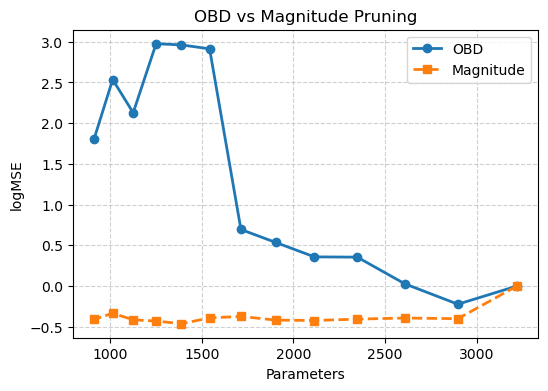

In [76]:
import matplotlib.pyplot as plt

def plot_mse_db_comparison(mse_list_obd, remaining_obd, mse_list_mag, remaining_mag):
    mse_list_obd = torch.tensor(mse_list_obd, dtype=torch.float32)
    mse_list_mag = torch.tensor(mse_list_mag, dtype=torch.float32)

    baseline_obd = mse_list_obd[0]
    baseline_mag = mse_list_mag[0]

    mse_db_obd = 10 * torch.log10(mse_list_obd / baseline_obd)
    mse_db_mag = 10 * torch.log10(mse_list_mag / baseline_mag)

    plt.figure(figsize=(6,4))
    plt.plot(remaining_obd, mse_db_obd, marker='o', linestyle='-', linewidth=2, label="OBD")
    plt.plot(remaining_mag, mse_db_mag, marker='s', linestyle='--', linewidth=2, label="Magnitude")

    plt.xlabel("Parameters")
    plt.ylabel("logMSE")
    plt.title("OBD vs Magnitude Pruning")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

# Call with your data
plot_mse_db_comparison(mse_list, remaining_params_list, mse_list_mag, remaining_params_list_mag)